In [1]:
import sys
import os
# from features_extraction.harralick import Harralick
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import logging
from torchvision import transforms
from PIL import Image
import random
import math
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
'''
FUNGSI GENERAL PREPROCESSING UNTUK MELAKUKAN PREPROCESSING SECARA UMUM SEBELUM MASUK KE SPESIFIK PREPROCESSING
'''

def general_preprocessing(file_path):
    try:
        # Load the image
        image = cv2.imread(file_path)
        if image is None:
            raise ValueError(f"Image not loaded: {file_path}")
        
        # Convert to grayscale (example preprocessing step)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize the image (example preprocessing step)
        image = cv2.resize(image, (128, 128))
        
        return image
    except Exception as e:
        print(f"Error in preprocessing {file_path}: {e}")
        return None

In [4]:
BASE_DIR = os.path.abspath("..")  # Naik satu level ke root proyek
# path ke dataset
dataset_path = os.path.join(BASE_DIR, "dataset") # Agar folder dataset dapat dibaca

In [7]:
dataset_path

'd:\\KULIAH\\TA\\Program\\dataset'

In [8]:
classes = ["20%", "40%", "60%", "80%", "100%"]

# Menyimpan data gambar dan label
data_baru = []
labels = []

# Iterasi setiap kelas
for label, category in enumerate(classes):
    folder_path = os.path.join(f'{dataset_path}/APPLE RIPENESS LEVELS IMAGE DATASET', f'{category}')
    # print(folder_path)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        image = general_preprocessing(file_path)
        
        if image is None:
            print(f"Skipping invalid image: {file_path}")
            continue

        # Save valid data
        data_baru.append(image)
        labels.append(label)

In [9]:
len(data_baru), len(labels)

(500, 500)

In [10]:
# Konversi ke array NumPy
data_baru = np.array(data_baru, dtype="float32")
labels = np.array(labels)

print("Jumlah data:", len(data_baru))
print("Jumlah label:", len(labels))

Jumlah data: 500
Jumlah label: 500


In [11]:
data_baru = data_baru.astype(np.uint16)
data_baru.shape

(500, 128, 128)

In [12]:
# Cek Nilai minimum dan maksimum
print(f"Nilai piksel minimum: {np.min(data_baru)}")
print(f"Nilai piksel maksimum: {np.max(data_baru)}")

Nilai piksel minimum: 1
Nilai piksel maksimum: 255


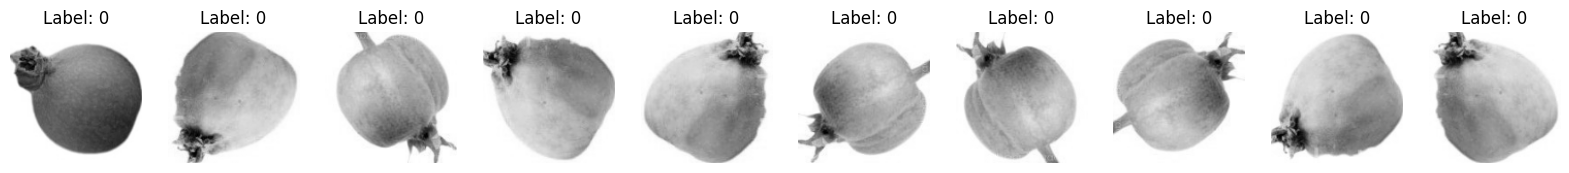

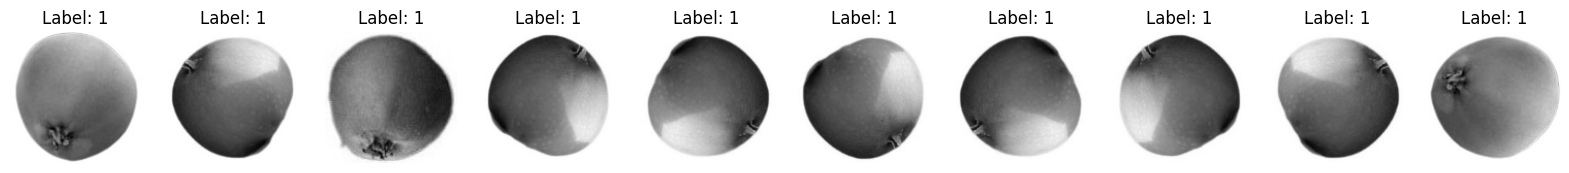

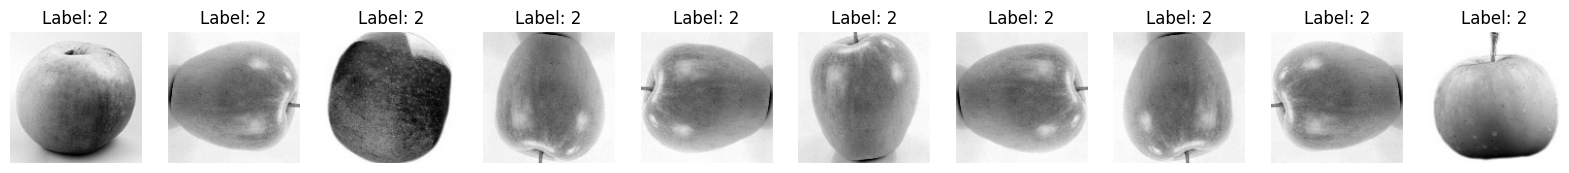

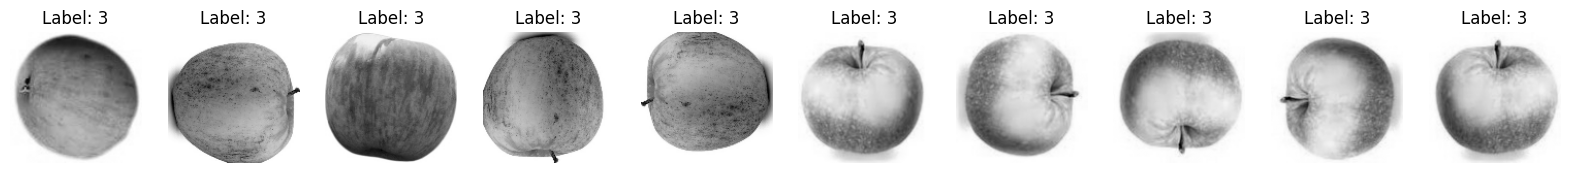

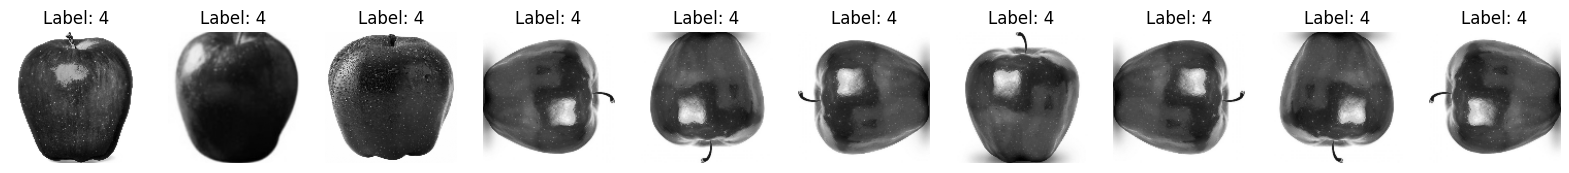

In [13]:
# Menampilkan 10 contoh gambar pertama
num_samples = 10
plt.figure(figsize=(20, 10))

# 10 Label 0 (20%)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data_baru[i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 1 (40%)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data_baru[100+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[100+i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 2 (60%)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data_baru[200+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[200+i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 2 (80%)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data_baru[300+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[300+i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 2 (100%)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data_baru[400+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[400+i]}")
    plt.axis("off")

plt.show()

In [14]:
# Fungsi untuk menghitung GLCM dan fitur Harralick
def calculate_additional_features(glcm):
    features = {}
    # Sum of squares: Variance
    features['sum_of_squares'] = np.sum((np.arange(glcm.shape[0]) - np.mean(glcm))**2 * glcm)

    # Sum average
    px_plus_py = np.sum(glcm, axis=0) + np.sum(glcm, axis=1)
    features['sum_average'] = np.sum(np.arange(len(px_plus_py)) * px_plus_py)

    # Sum variance
    features['sum_variance'] = np.sum((np.arange(len(px_plus_py)) - features['sum_average'])**2 * px_plus_py)

    # Sum entropy
    features['sum_entropy'] = -np.sum(px_plus_py * np.log2(px_plus_py + 1e-10))

    # Difference variance
    px_minus_py = np.abs(np.sum(glcm, axis=0) - np.sum(glcm, axis=1))
    features['difference_variance'] = np.var(px_minus_py)

    # Difference entropy
    features['difference_entropy'] = -np.sum(px_minus_py * np.log2(px_minus_py + 1e-10))

    # Information measure of correlation 1
    hxy = -np.sum(glcm * np.log2(glcm + 1e-10))
    hxy1 = -np.sum(np.sum(glcm, axis=0) * np.log2(np.sum(glcm, axis=0) + 1e-10))
    hxy2 = -np.sum(np.sum(glcm, axis=1) * np.log2(np.sum(glcm, axis=1) + 1e-10))
    features['IMC1'] = (hxy - hxy1) / max(hxy, hxy2)

    # Information measure of correlation 2
    hx = -np.sum(np.sum(glcm, axis=0) * np.log2(np.sum(glcm, axis=0) + 1e-10))
    hy = -np.sum(np.sum(glcm, axis=1) * np.log2(np.sum(glcm, axis=1) + 1e-10))
    features['IMC2'] = np.sqrt(1 - np.exp(-2 * (hxy - hx - hy)))

    return features

In [16]:
# Kombinasi d dan theta
kombinasiFeature = [[1, 2, 3], [0, 45, 90, 135]]  # Angles in degrees

# Dictionary to store DataFrames for each combination
feature_dataframes_test = {}

for d in kombinasiFeature[0]:
    for theta in kombinasiFeature[1]:
        data_fitur = []  # List untuk menyimpan fitur semua gambar untuk kombinasi ini
        img = 0  # Index untuk data
        for index in range(len(data_baru)):
            try:
                # Konversi sudut ke radian untuk perhitungan
                theta_in_radians = np.deg2rad(theta)

                # Hitung Matriks GLCM
                glcm_matrix = graycomatrix(data_baru[index], distances=[d], angles=[theta_in_radians], levels=256, symmetric=True, normed=True)

                # Hitung fitur Haralick dari matriks GLCM
                features = {
                    'contrast': graycoprops(glcm_matrix, 'contrast')[0, 0],
                    'dissimilarity': graycoprops(glcm_matrix, 'dissimilarity')[0, 0],
                    'homogeneity': graycoprops(glcm_matrix, 'homogeneity')[0, 0],
                    'energy': graycoprops(glcm_matrix, 'energy')[0, 0],
                    'correlation': graycoprops(glcm_matrix, 'correlation')[0, 0],
                    'ASM': graycoprops(glcm_matrix, 'ASM')[0, 0],
                    'image': f'img-{img}',
                    'label': labels[index]
                }

                # Tambahkan fitur tambahan jika diperlukan
                additional_features = calculate_additional_features(glcm_matrix[:, :, 0, 0])
                features.update(additional_features)

                data_fitur.append(features)
                img += 1
            except Exception as e:
                print(e)

        # Simpan DataFrame ke dictionary dengan kunci (d, theta dalam derajat)
        if data_fitur:
            df = pd.DataFrame(data_fitur)
            feature_dataframes_test[(d, theta)] = df
            print(f"Data untuk d={d}, theta={theta} berhasil dihitung dan disimpan ke dalam memori!")
            # Simpan data ke csv
            df.to_csv(f"{dataset_path}/ExtractResult//harralick/features_d{d}_theta{theta}.csv", index=False)
        else:
            print(f"Tidak ada data untuk d={d}, theta={theta}. Tidak ada DataFrame yang dibuat.")
        

# Contoh analisis:
# print(feature_dataframes_test[(1, 0)].head())  # Menampilkan data untuk d=1, theta=0

C:\Users\Deva\AppData\Local\Temp\ipykernel_28512\3100909436.py:33: RuntimeWarning: invalid value encountered in sqrt
  features['IMC2'] = np.sqrt(1 - np.exp(-2 * (hxy - hx - hy)))


Data untuk d=1, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=135 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=135 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=135 berhasil dihitung dan disimpan ke dalam memori!


In [ ]:
# Kombinasi d dan theta
kombinasiFeature = [[1, 2, 3], [0, 45, 90, 135]]  # Angles in degrees

# Dictionary to store DataFrames for each combination
feature_dataframes = {}

for d in kombinasiFeature[0]:
    for theta in kombinasiFeature[1]:
        data_fitur = []  # List untuk menyimpan fitur semua gambar untuk kombinasi ini
        img = [index for index in range(500)]  # Index untuk data

        df = pd.read_csv(f"{dataset_path}/ExtractResult/harralick/features_d{d}_theta{theta}.csv")
        df['image'] = img
        
        feature_dataframes[(d, theta)] = df
        print(f"Data untuk d={d}, theta={theta} berhasil dihitung dan disimpan ke dalam memori!")

Data untuk d=1, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=135 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=135 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=135 berhasil dihitung dan disimpan ke dalam memori!


In [17]:
feature_dataframes_test.keys()

dict_keys([(1, 0), (1, 45), (1, 90), (1, 135), (2, 0), (2, 45), (2, 90), (2, 135), (3, 0), (3, 45), (3, 90), (3, 135)])

In [ ]:
df_test = feature_dataframes_test[(1, 45)].copy()  # Copy 
df_test = df_test.set_index('image')

In [166]:
df_test.head()

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,sum_of_squares,sum_average,sum_variance,sum_entropy,difference_variance,difference_entropy,IMC1,IMC2
image,,,,,,,,,,,,,,,
img-0,170.169074,5.243040,0.454199,0.275247,0.982823,0.075761,0,33375.443085,337.176328,66750.896460,9.529845,4.280309e-36,1.084724e-14,0.350331,NaN
img-1,134.079670,5.363941,0.377222,0.153950,0.973539,0.023701,0,40790.904844,391.189968,81581.821626,11.008009,7.757876e-36,1.513590e-14,0.354075,NaN
img-2,92.735631,4.597495,0.426336,0.241084,0.979740,0.058121,0,43746.253908,407.223076,87492.520243,9.748284,2.282331e-36,6.402818e-15,0.358461,NaN
img-3,123.654845,5.014756,0.396006,0.150844,0.975562,0.022754,0,40781.855368,391.161696,81563.722673,11.048323,7.623568e-36,1.522234e-14,0.347516,NaN
img-4,134.580755,5.389981,0.373784,0.147675,0.973381,0.021808,0,40772.555350,391.124744,81545.122636,11.082890,4.309333e-36,1.307036e-14,0.354128,NaN


In [156]:
df_test.isnull().sum()

contrast                 0
dissimilarity            0
homogeneity              0
energy                   0
correlation              0
ASM                      0
label                    0
sum_of_squares           0
sum_average              0
sum_variance             0
sum_entropy              0
difference_variance      0
difference_entropy       0
IMC1                     0
IMC2                   500
dtype: int64

In [ ]:
# Pisahkan fitur (X) dan label (y)
X = df_test.drop(columns=['label', 'IMC2'])  # Semua kolom kecuali 'label' dan 'IMC2'
y = df_test['label']  # Kolom 'label'

# Bagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [158]:
# Inisialisasi model KNN
for k in range(3, 22, 2):
    knn = KNeighborsClassifier(n_neighbors=k)  # Gunakan 3 tetangga terdekat (k=3)

    # Latih model dengan data training
    knn.fit(X_train, y_train)

    # Prediksi label untuk data testing
    y_pred = knn.predict(X_test)

    # Evaluasi performa model
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Accuracy Score:")
    print(accuracy_score(y_test, y_pred))

    print('-----------------------------------------')

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        39
           1       0.82      1.00      0.90        23
           2       0.85      0.88      0.87        26
           3       0.93      0.90      0.92        31
           4       0.86      0.77      0.81        31

    accuracy                           0.89       150
   macro avg       0.88      0.89      0.88       150
weighted avg       0.89      0.89      0.89       150

Accuracy Score:
0.8866666666666667
-----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88        39
           1       0.70      1.00      0.82        23
           2       0.83      0.92      0.87        26
           3       0.90      0.84      0.87        31
           4       0.72      0.58      0.64        31

    accuracy                           0.82       150
   macro

In [224]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Dictionary untuk menyimpan hasil akurasi dan neighbors info
results = {}
neighbors_info = {}

# Iterasi melalui semua kombinasi (d, theta)
for (d, theta), df in feature_dataframes_test.items():
    print(f"Evaluating combination d={d}, theta={theta}...")
    
    numeric_features = df.drop(columns=['label', 'IMC2', 'image'], axis=1).columns

    df_ngetestt = df.copy()
    scaler = MinMaxScaler()
    df_ngetestt[numeric_features] = scaler.fit_transform(df_ngetestt[numeric_features])

    # Pisahkan fitur (X) dan label (y)
    X = df_ngetestt.drop(columns=['label','IMC2', 'image'], axis=1)  # Semua kolom kecuali 'image' dan 'label'
    y = df_ngetestt['label']  # Kolom 'label'

    # Bagi data menjadi training dan testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Dictionary untuk menyimpan akurasi per nilai k
    accuracy_per_k = {}
    neighbors_per_k = {}

    # Coba nilai k dari 3 hingga 15
    for k in range(3, 22, 2):
        # Inisialisasi model KNN
        knn = KNeighborsClassifier(n_neighbors=k)

        # Latih model dengan data training
        knn.fit(X_train, y_train)

        # Get the distances and indices of the k nearest neighbors for the test set
        distances, indices = knn.kneighbors(X_test)

        # Simpan distances dan indices untuk k ini
        neighbors_per_k[k] = {'distances': distances, 'indices': indices}

        # Prediksi label untuk data testing
        y_pred = knn.predict(X_test)

        # Hitung akurasi
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_per_k[k] = accuracy

    # Simpan hasil akurasi dan neighbors info untuk kombinasi (d, theta)
    results[(d, theta)] = accuracy_per_k
    neighbors_info[(d, theta)] = neighbors_per_k

# Tampilkan hasil
for (d, theta), accuracies in results.items():
    print(f"\nResults for d={d}, theta={theta}:")
    for k, acc in accuracies.items():
        print(f"  k={k}: Accuracy={acc:.2f}")

Evaluating combination d=1, theta=0...
Evaluating combination d=1, theta=45...
Evaluating combination d=1, theta=90...
Evaluating combination d=1, theta=135...
Evaluating combination d=2, theta=0...
Evaluating combination d=2, theta=45...
Evaluating combination d=2, theta=90...
Evaluating combination d=2, theta=135...
Evaluating combination d=3, theta=0...
Evaluating combination d=3, theta=45...
Evaluating combination d=3, theta=90...
Evaluating combination d=3, theta=135...

Results for d=1, theta=0:
  k=3: Accuracy=0.93
  k=5: Accuracy=0.84
  k=7: Accuracy=0.76
  k=9: Accuracy=0.75
  k=11: Accuracy=0.76
  k=13: Accuracy=0.72
  k=15: Accuracy=0.69
  k=17: Accuracy=0.64
  k=19: Accuracy=0.59
  k=21: Accuracy=0.59

Results for d=1, theta=45:
  k=3: Accuracy=0.94
  k=5: Accuracy=0.87
  k=7: Accuracy=0.85
  k=9: Accuracy=0.80
  k=11: Accuracy=0.79
  k=13: Accuracy=0.75
  k=15: Accuracy=0.73
  k=17: Accuracy=0.67
  k=19: Accuracy=0.67
  k=21: Accuracy=0.62

Results for d=1, theta=90:
  k=3

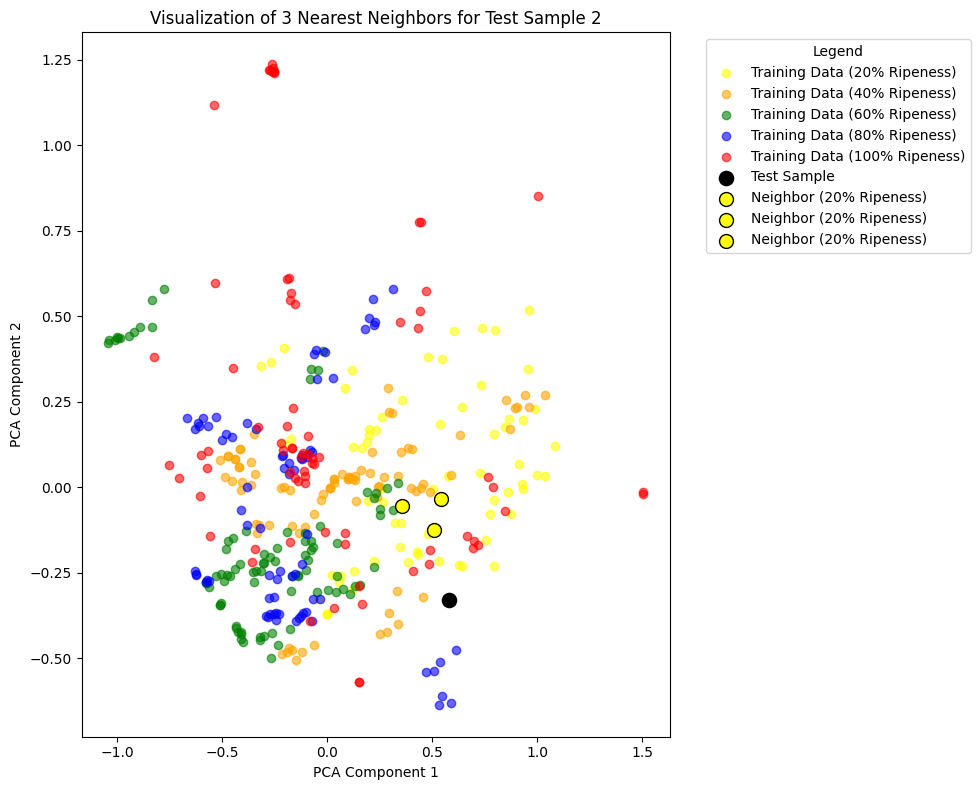

In [215]:
# Menentukan warna untuk setiap label
label_colors = {0: 'yellow', 1: 'orange', 2: 'green', 3: 'blue', 4: 'red'}
label_names = {0: '20% Ripeness', 1: '40% Ripeness', 2: '60% Ripeness', 3: '80% Ripeness', 4: '100% Ripeness'}
default_color = 'gray'

# Pilih kombinasi (d, theta) dan nilai k yang ingin divisualisasikan
d, theta = 1, 0  # Contoh kombinasi
k = 3  # Contoh k value

# Dapatkan tetangga untuk kombinasi yang dipilih dan k
distances = neighbors_info[(d, theta)][k]['distances']
indices = neighbors_info[(d, theta)][k]['indices']

# Kurangi fitur menjadi 2D menggunakan PCA
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Ubah y_train menjadi array NumPy
y_train_array = np.array(y_train)

# Visualisasikan sampel uji dan tetangganya
test_sample_idx = 1  # Contoh sampel uji (ini adlaah indeks data X_test)
neighbors_idx = indices[test_sample_idx] # Indeks tetangga terdekat untuk sampel uji

plt.figure(figsize=(10, 8))

# Plot data pelatihan dengan kode warna berdasarkan label
for label in np.unique(y_train_array):
    plt.scatter(
        X_train_2d[y_train_array == label, 0],
        X_train_2d[y_train_array == label, 1],
        c=label_colors.get(label, default_color),
        label=f'Training Data ({label_names.get(label, "Unknown")})',
        alpha=0.6
    )

# Sorot sampel uji
plt.scatter(
    X_test_2d[test_sample_idx, 0],
    X_test_2d[test_sample_idx, 1],
    c='black',
    label='Test Sample',
    edgecolor='white',
    s=150
)

# Sorot tetangga terdekat
for neighbor_idx in neighbors_idx:
    plt.scatter(
        X_train_2d[neighbor_idx, 0],
        X_train_2d[neighbor_idx, 1],
        c=label_colors.get(y_train_array[neighbor_idx], default_color),
        edgecolor='black',
        s=100,
        label=f'Neighbor ({label_names.get(y_train_array[neighbor_idx], "Unknown")})'
    )

# Tambahkan legend dan label
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title="Legend")
plt.title(f'Visualization of {k} Nearest Neighbors for Test Sample {test_sample_idx + 1}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()

In [225]:
# Menemukan K terbaik dari seluruh kombinasi dataset
counter = 0
for (d, theta), accuracies in results.items():
    print(f"{d},{theta} ==> {max(accuracies.values()):.2f}")
    if max(accuracies.values()):
        print(f"Best k for d={d}, theta={theta}: {max(accuracies, key=accuracies.get)}")
        max_accuracy = max(accuracies.values())
    print('=----------------=')
    if max_accuracy > counter:
        counter = max_accuracy
        best_combination = (d, theta)
        best_k = max(accuracies, key=accuracies.get)

print(f"\nBest combination: d={best_combination[0]}, theta={best_combination[1]} with k={best_k} and accuracy={counter:.2f}")

1,0 ==> 0.93
Best k for d=1, theta=0: 3
=----------------=
1,45 ==> 0.94
Best k for d=1, theta=45: 3
=----------------=
1,90 ==> 0.92
Best k for d=1, theta=90: 3
=----------------=
1,135 ==> 0.93
Best k for d=1, theta=135: 3
=----------------=
2,0 ==> 0.94
Best k for d=2, theta=0: 3
=----------------=
2,45 ==> 0.94
Best k for d=2, theta=45: 3
=----------------=
2,90 ==> 0.91
Best k for d=2, theta=90: 3
=----------------=
2,135 ==> 0.93
Best k for d=2, theta=135: 3
=----------------=
3,0 ==> 0.91
Best k for d=3, theta=0: 3
=----------------=
3,45 ==> 0.93
Best k for d=3, theta=45: 3
=----------------=
3,90 ==> 0.86
Best k for d=3, theta=90: 3
=----------------=
3,135 ==> 0.90
Best k for d=3, theta=135: 3
=----------------=

Best combination: d=1, theta=45 with k=3 and accuracy=0.94


Di atas adalah contoh tanpa ada pemrosesan data lebih lanjut, sekarang mari coba untuk melakukan sedikit feature selection

## Features Selection 

In [34]:
df_ngetestt.describe()

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,sum_of_squares,sum_average,sum_variance,sum_entropy,difference_variance,difference_entropy,IMC1,IMC2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,0.0
mean,0.254556,0.353209,0.420504,0.362497,0.700807,0.200382,2.00000,0.553020,0.651332,0.553020,0.584235,6.171033e-36,0.383499,0.372520,NaN
std,0.177414,0.181476,0.212487,0.228632,0.147637,0.203946,1.41563,0.175724,0.153878,0.175724,0.182174,6.411770e-36,0.183102,0.201630,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN
25%,0.129870,0.239488,0.249836,0.176099,0.624991,0.044642,1.00000,0.449915,0.550634,0.449915,0.456708,1.963512e-36,0.241224,0.220597,NaN
50%,0.221493,0.326084,0.397884,0.335185,0.721698,0.133284,2.00000,0.559438,0.651261,0.559438,0.599491,4.621958e-36,0.356938,0.341950,NaN
75%,0.329472,0.444738,0.595152,0.515907,0.779124,0.289624,3.00000,0.683469,0.774297,0.683469,0.723421,8.317508e-36,0.502255,0.526619,NaN
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.00000,1.000000,1.000000,1.000000,1.000000,5.167714e-35,1.000000,1.000000,NaN


Jika melihat pada fitur seperti sum_of_squares, sum_average, dan sum_variance, itu memiliki kecenderungan redudansi terutama sum_of_squares dan sum_variance. Jadi salah satunya harus dibuang fiturnya.

Selain itu, fitur IMC2 juga akan dibuang karena semua mengandung NaN.

Mari lihat lebih jelasnya dengan matriks korelasi

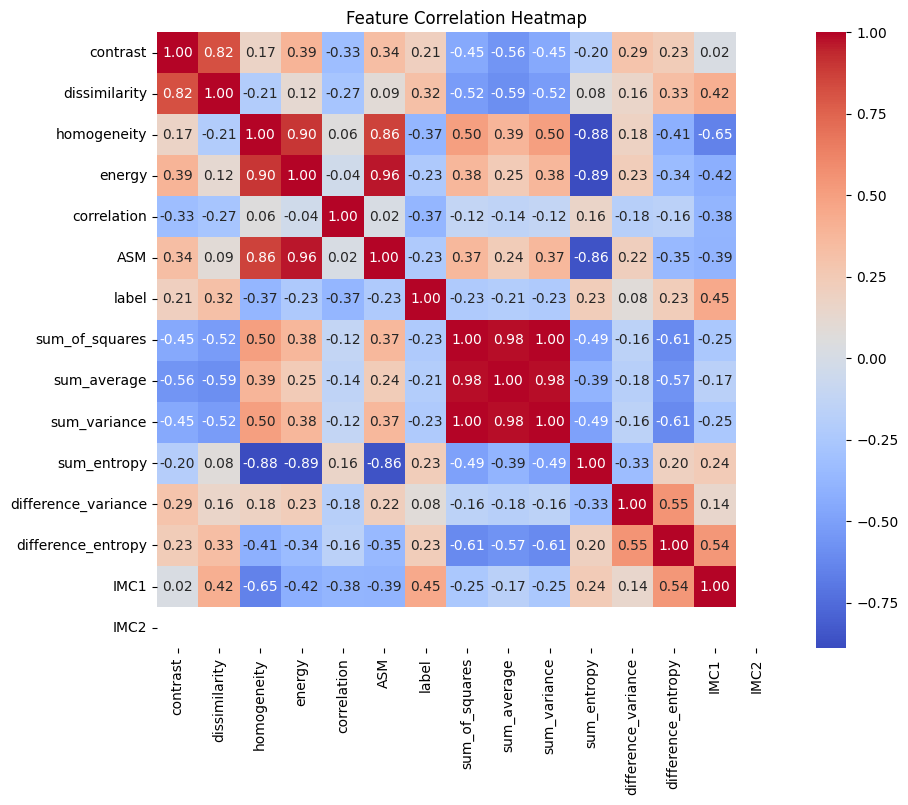

In [ ]:
# Hitung dan visualisasikan matriks korelasi
correlation_matrix = df_ngetestt.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Terlihat bahwa ada beberapa yang memiliki korelasi yang sangat tinggi, tetapi bukan terhadap label, jadi harus dibuang salah satunya.

Fitur yang akan dibuang meliputi, 'homogeneity','sum_variance', 'ASM', dan 'IMC2'.

## Classification after Features Selection

In [222]:
# Dictionary untuk menyimpan hasil akurasi dan neighbors info
results = {}
neighbors_info = {}

# Iterasi melalui semua kombinasi (d, theta)
for (d, theta), df in feature_dataframes_test.items():
    print(f"Evaluating combination d={d}, theta={theta}...")
    
    numeric_features = df.drop(columns=['label', 'IMC2', 'image'], axis=1).columns

    df_ngetestt = df.copy()
    scaler = MinMaxScaler()
    df_ngetestt[numeric_features] = scaler.fit_transform(df_ngetestt[numeric_features])

    # Pisahkan fitur (X) dan label (y)
    X = df_ngetestt.drop(columns=['label','homogeneity','sum_variance', 'ASM','IMC2', 'image'], axis=1)  # Kolom yang dibuang
    y = df_ngetestt['label']  # Kolom 'label'

    # Bagi data menjadi training dan testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Dictionary untuk menyimpan akurasi per nilai k
    accuracy_per_k = {}
    neighbors_per_k = {}

    # Coba nilai k dari 3 hingga 21
    for k in range(3, 22, 2):
        # Inisialisasi model KNN
        knn = KNeighborsClassifier(n_neighbors=k)

        # Latih model dengan data training
        knn.fit(X_train, y_train)

        # Get the distances and indices of the k nearest neighbors for the test set
        distances, indices = knn.kneighbors(X_test)

        # Simpan distances dan indices untuk k ini
        neighbors_per_k[k] = {'distances': distances, 'indices': indices}

        # Prediksi label untuk data testing
        y_pred = knn.predict(X_test)

        # Hitung akurasi
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_per_k[k] = accuracy

    # Simpan hasil akurasi dan neighbors info untuk kombinasi (d, theta)
    results[(d, theta)] = accuracy_per_k
    neighbors_info[(d, theta)] = neighbors_per_k

# Tampilkan hasil
for (d, theta), accuracies in results.items():
    print(f"\nResults for d={d}, theta={theta}:")
    for k, acc in accuracies.items():
        print(f"  k={k}: Accuracy={acc:.2f}")

Evaluating combination d=1, theta=0...
Evaluating combination d=1, theta=45...
Evaluating combination d=1, theta=90...
Evaluating combination d=1, theta=135...
Evaluating combination d=2, theta=0...
Evaluating combination d=2, theta=45...
Evaluating combination d=2, theta=90...
Evaluating combination d=2, theta=135...
Evaluating combination d=3, theta=0...
Evaluating combination d=3, theta=45...
Evaluating combination d=3, theta=90...
Evaluating combination d=3, theta=135...

Results for d=1, theta=0:
  k=3: Accuracy=0.93
  k=5: Accuracy=0.84
  k=7: Accuracy=0.80
  k=9: Accuracy=0.75
  k=11: Accuracy=0.76
  k=13: Accuracy=0.73
  k=15: Accuracy=0.70
  k=17: Accuracy=0.66
  k=19: Accuracy=0.62
  k=21: Accuracy=0.61

Results for d=1, theta=45:
  k=3: Accuracy=0.96
  k=5: Accuracy=0.89
  k=7: Accuracy=0.85
  k=9: Accuracy=0.81
  k=11: Accuracy=0.78
  k=13: Accuracy=0.75
  k=15: Accuracy=0.75
  k=17: Accuracy=0.68
  k=19: Accuracy=0.66
  k=21: Accuracy=0.65

Results for d=1, theta=90:
  k=3

In [223]:
# Menemukan K terbaik dari seluruh kombinasi dataset
counter = 0
for (d, theta), accuracies in results.items():
    print(f"{d},{theta} ==> {max(accuracies.values()):.2f}")
    if max(accuracies.values()):
        print(f"Best k for d={d}, theta={theta}: {max(accuracies, key=accuracies.get)}")
        max_accuracy = max(accuracies.values())
    print('=----------------=')
    if max_accuracy > counter:
        counter = max_accuracy
        best_combination = (d, theta)
        best_k = max(accuracies, key=accuracies.get)

print(f"\nBest combination: d={best_combination[0]}, theta={best_combination[1]} with k={best_k} and accuracy={counter:.2f}")

1,0 ==> 0.93
Best k for d=1, theta=0: 3
=----------------=
1,45 ==> 0.96
Best k for d=1, theta=45: 3
=----------------=
1,90 ==> 0.93
Best k for d=1, theta=90: 3
=----------------=
1,135 ==> 0.94
Best k for d=1, theta=135: 3
=----------------=
2,0 ==> 0.92
Best k for d=2, theta=0: 3
=----------------=
2,45 ==> 0.96
Best k for d=2, theta=45: 3
=----------------=
2,90 ==> 0.91
Best k for d=2, theta=90: 3
=----------------=
2,135 ==> 0.94
Best k for d=2, theta=135: 3
=----------------=
3,0 ==> 0.89
Best k for d=3, theta=0: 3
=----------------=
3,45 ==> 0.94
Best k for d=3, theta=45: 3
=----------------=
3,90 ==> 0.87
Best k for d=3, theta=90: 3
=----------------=
3,135 ==> 0.90
Best k for d=3, theta=135: 3
=----------------=

Best combination: d=1, theta=45 with k=3 and accuracy=0.96


Oke terlihat ada peningkatan akurasi tertinggi, yaitu sebesar 2% peningkatan dari yang awalnya hanya 94% sekarang menjadi 96%.

## Evaluation

Sebelumnya didapat akurasi tertinggi sebesar 96% untuk kombinasi dataset d=1, theta=45, dan k=3. 

Sekarang mari coba melihat metrik evaluasi lain terhadap kombinasi tersebut.

In [ ]:
df_best = feature_dataframes_test[best_combination].copy() # buat salinan dari dataset dengan kombinasi terbaik
df_best 

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,image,label,sum_of_squares,sum_average,sum_variance,sum_entropy,difference_variance,difference_entropy,IMC1,IMC2
0,170.169074,5.243040,0.454199,0.275247,0.982823,0.075761,img-0,0,33375.443085,337.176328,66750.896460,9.529845,4.280309e-36,1.084724e-14,0.350331,NaN
1,134.079670,5.363941,0.377222,0.153950,0.973539,0.023701,img-1,0,40790.904844,391.189968,81581.821626,11.008009,7.757876e-36,1.513590e-14,0.354075,NaN
2,92.735631,4.597495,0.426336,0.241084,0.979740,0.058121,img-2,0,43746.253908,407.223076,87492.520243,9.748284,2.282331e-36,6.402818e-15,0.358461,NaN
3,123.654845,5.014756,0.396006,0.150844,0.975562,0.022754,img-3,0,40781.855368,391.161696,81563.722673,11.048323,7.623568e-36,1.522234e-14,0.347516,NaN
4,134.580755,5.389981,0.373784,0.147675,0.973381,0.021808,img-4,0,40772.555350,391.124744,81545.122636,11.082890,4.309333e-36,1.307036e-14,0.354128,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,153.614607,6.916238,0.328482,0.190010,0.964735,0.036104,img-495,4,37080.460850,373.643871,74160.933102,9.427772,5.946111e-36,7.528331e-15,0.408870,NaN
496,154.357927,6.695207,0.329018,0.183176,0.964519,0.033554,img-496,4,37046.839456,373.479013,74093.690309,9.493720,3.117751e-36,6.971878e-15,0.405806,NaN
497,569.899994,10.872776,0.379308,0.281821,0.963405,0.079423,img-497,4,27891.300744,283.582429,55782.610143,9.542955,6.090702e-36,8.282875e-15,0.388212,NaN
498,430.864096,6.566371,0.553182,0.434277,0.974347,0.188596,img-498,4,37634.664724,341.974766,75269.339885,7.142230,1.314559e-35,5.772531e-15,0.355054,NaN


Mari lakukan sedikit preprocessing yang sama

In [ ]:
df_best = df_best.set_index('image') # Set index ke kolom 'image'
df_best = df_best.drop(columns=['IMC2'], axis=1)  # Hapus kolom IMC2
df_best.head()

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,sum_of_squares,sum_average,sum_variance,sum_entropy,difference_variance,difference_entropy,IMC1
image,,,,,,,,,,,,,,
img-0,170.169074,5.243040,0.454199,0.275247,0.982823,0.075761,0,33375.443085,337.176328,66750.896460,9.529845,4.280309e-36,1.084724e-14,0.350331
img-1,134.079670,5.363941,0.377222,0.153950,0.973539,0.023701,0,40790.904844,391.189968,81581.821626,11.008009,7.757876e-36,1.513590e-14,0.354075
img-2,92.735631,4.597495,0.426336,0.241084,0.979740,0.058121,0,43746.253908,407.223076,87492.520243,9.748284,2.282331e-36,6.402818e-15,0.358461
img-3,123.654845,5.014756,0.396006,0.150844,0.975562,0.022754,0,40781.855368,391.161696,81563.722673,11.048323,7.623568e-36,1.522234e-14,0.347516
img-4,134.580755,5.389981,0.373784,0.147675,0.973381,0.021808,0,40772.555350,391.124744,81545.122636,11.082890,4.309333e-36,1.307036e-14,0.354128


In [229]:
numeric_features = df_best.drop(columns=['label'], axis=1).columns

df_best_normal = df_best.copy()
scaler = MinMaxScaler()
df_best_normal[numeric_features] = scaler.fit_transform(df_best_normal[numeric_features])

In [230]:
df_best_normal.head()

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,sum_of_squares,sum_average,sum_variance,sum_entropy,difference_variance,difference_entropy,IMC1
image,,,,,,,,,,,,,,
img-0,0.184054,0.229873,0.656995,0.603277,0.886083,0.391193,0,0.462438,0.561217,0.462438,0.402297,3.391416e-36,0.515132,0.294779
img-1,0.134821,0.242284,0.465080,0.309112,0.783994,0.119866,0,0.673711,0.764368,0.673711,0.651357,6.868982e-36,0.816703,0.329662
img-2,0.078419,0.163604,0.587529,0.520426,0.852177,0.299260,0,0.757911,0.824670,0.757911,0.439102,1.393437e-36,0.202609,0.370533
img-3,0.120599,0.206439,0.511910,0.301578,0.806243,0.114931,0,0.673453,0.764262,0.673453,0.658150,6.734674e-36,0.822781,0.268550
img-4,0.135504,0.244958,0.456509,0.293892,0.782260,0.110001,0,0.673188,0.764123,0.673188,0.663974,3.420439e-36,0.671458,0.330162


Sekarang mari lakukan klasifikasi dengan k = 3

In [240]:
X_train, X_test, y_train, y_test = train_test_split(df_best_normal.drop(columns=['label','homogeneity','sum_variance', 'ASM'], axis=1), df_best_normal['label'], test_size=0.2, random_state=42)

In [241]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
# Latih model dengan data training
knn.fit(X_train, y_train)
# Prediksi label untuk data testing
y_pred = knn.predict(X_test)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [242]:
print(report)
print(accuracy)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10
           3       0.89      1.00      0.94        24
           4       1.00      0.83      0.91        24

    accuracy                           0.96       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.96      0.96      0.96       100

0.96


In [243]:
confusion_matrix.style.background_gradient(cmap='Blues').set_caption("Confusion Matrix for KNN Classifier")

Predicted,0,1,2,3,4,All
Actual,,,,,,
0,28,0,0,0,0,28
1,0,14,0,0,0,14
2,0,0,10,0,0,10
3,0,0,0,24,0,24
4,1,0,0,3,20,24
All,29,14,10,27,20,100


In [249]:
y_test.value_counts()

label
0    28
3    24
4    24
1    14
2    10
Name: count, dtype: int64

In [264]:
unik, hitungan = np.unique(y_pred, return_counts=True)

In [263]:
unik, hitungan

(array([0, 1, 2, 3, 4]), array([29, 14, 10, 27, 20]))